In this notebook we use GCN to analyze the POIs networks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.layers import Dense
from keras.models import Sequential
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchtext
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch_geometric
import itertools
import nltk
import spacy
import random
from tqdm import tqdm
import time
from IPython.display import Javascript

In [4]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter
import random
import csv
import os
import sys
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, classification_report

In [5]:
random.seed(10)

In [6]:
df = pd.read_csv('./datasets/la_label.csv')

In [7]:
df.tail(10)

,Unnamed: 0,Label (Grouping),Unemployment Rate,"Agriculture, forestry, fishing and hunting, and mining",Construction,Manufacturing,Wholesale trade,Retail trade,"Transportation and warehousing, and utilities",Information,...,typology_y,typ_cat_y,label_y,USPS,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
1727,1727,9203.36,0.07,0.00,0.07,0.08,0.01,0.09,0.06,0.02,...,1.0,['LISD'],0.0,CA,1656822,967,0.640,0.000,34.385597,-118.535884
1728,1728,9203.37,0.08,0.00,0.11,0.14,0.01,0.11,0.04,0.04,...,6.0,['SMMI'],0.0,CA,1648101,0,0.636,0.000,34.373662,-118.512874
1729,1729,9203.38,0.09,0.00,0.03,0.09,0.04,0.09,0.03,0.09,...,9.0,['SAE'],0.0,CA,3715461,0,1.435,0.000,34.386084,-118.596430
1730,1730,9203.39,0.05,0.01,0.04,0.13,0.03,0.10,0.02,0.07,...,9.0,['SAE'],0.0,CA,33718926,228821,13.019,0.088,34.415357,-118.612172
1731,1731,9303.01,0.00,0.00,0.10,0.08,0.11,0.13,0.00,0.00,...,6.0,['SMMI'],0.0,CA,1028565621,4125839,397.131,1.593,34.280333,-117.866141
1732,1732,9800.15,0.12,0.00,0.13,0.07,0.02,0.08,0.05,0.00,...,1.0,['LISD'],0.0,CA,5188936,220674,2.003,0.085,33.773247,-118.288839
1733,1733,9800.19,0.09,0.00,0.00,0.00,0.10,0.05,0.11,0.05,...,9.0,['SAE'],0.0,CA,44210349,31076,17.070,0.012,34.092567,-118.534363
1734,1734,9800.21,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,2.0,['OD'],0.0,CA,6380469,565373,2.464,0.218,34.270047,-118.381334
1735,1735,9800.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.0,['ARE'],0.0,CA,12492183,13434637,4.823,5.187,33.739090,-118.258539
1736,1736,9901.00,-,-,-,-,-,-,-,-,...,3.0,['ARG'],1.0,CA,5606686,1665633,2.165,0.643,32.685362,-117.245574


In [8]:
df.columns

Index(['Unnamed: 0', 'Label (Grouping)', 'Unemployment Rate',
       'Agriculture, forestry, fishing and hunting, and mining',
       'Construction', 'Manufacturing', 'Wholesale trade', 'Retail trade',
       'Transportation and warehousing, and utilities', 'Information',
       'Finance and insurance, and real estate and rental and leasing',
       'Professional, scientific, and management, and administrative and waste management services',
       'Educational services, and health care and social assistance',
       'Arts, entertainment, and recreation, and accommodation and food services',
       'Other services, except public administration', 'Public administration',
       'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Less than $10,000',
       'HEALTH INSURANCE COVERAGE With health insurance coverage',
       'HEALTH INSURANCE COVERAGE With private health insurance',
       'YEAR STRUCTURE BUILT Built 2014 or later',
       'YEAR STRUCTURE BUILT Built 2010 to 2013',
  

In [9]:
ids = df['GEOID']
labels = df['label_y']
lats = df['INTPTLAT']
longs = df['INTPTLONG                                                                                                                             ']

In [10]:
la_lat_n = 34.746448
la_lat_s = 33.4
la_long_w = -118.861046
la_long_e = -117.015579

In [11]:
tracts = pd.DataFrame(list(zip(ids, lats, longs, labels)))
tracts.columns = ['id', 'lat', 'long', 'label']

In [12]:
tracts.describe()

,id,lat,long,label
count,1.737000e+03,1737.000000,1737.000000,1737.000000
mean,6.037900e+09,34.055732,-118.234390,0.157168
std,4.106899e+06,0.242663,0.240820,0.364063
min,6.037101e+09,32.683618,-118.861046,0.000000
25%,6.037211e+09,33.954281,-118.385506,0.000000
50%,6.037408e+09,34.055860,-118.265898,0.000000
75%,6.037570e+09,34.160209,-118.124438,0.000000
max,6.073010e+09,34.746448,-117.015579,1.000000


In [13]:
tracts.tail(10)

,id,lat,long,label
1727,6.037920e+09,34.385597,-118.535884,0.0
1728,6.037920e+09,34.373662,-118.512874,0.0
1729,6.037920e+09,34.386084,-118.596430,0.0
1730,6.037920e+09,34.415357,-118.612172,0.0
1731,6.037930e+09,34.280333,-117.866141,0.0
1732,6.037980e+09,33.773247,-118.288839,0.0
1733,6.037980e+09,34.092567,-118.534363,0.0
1734,6.037980e+09,34.270047,-118.381334,0.0
1735,6.037980e+09,33.739090,-118.258539,0.0
1736,6.073010e+09,32.685362,-117.245574,1.0


In [14]:
for index, row in tracts.iterrows():
    if (row['lat'] > la_lat_n or row['lat'] < la_lat_s or
            row['long'] > la_long_e or row['long'] < la_long_w):
        tracts = tracts.drop([index])

In [15]:
city_graph = nx.Graph()
color_map = []
for index, row in tracts.iterrows():
    city_graph.add_node((row['long'], row['lat']),
                        pos=(row['long'], row['lat']),
                        label=row['label'])
    if row['label'] == 1:
        color_map.append('steelblue')
    else:
        color_map.append('lightblue')

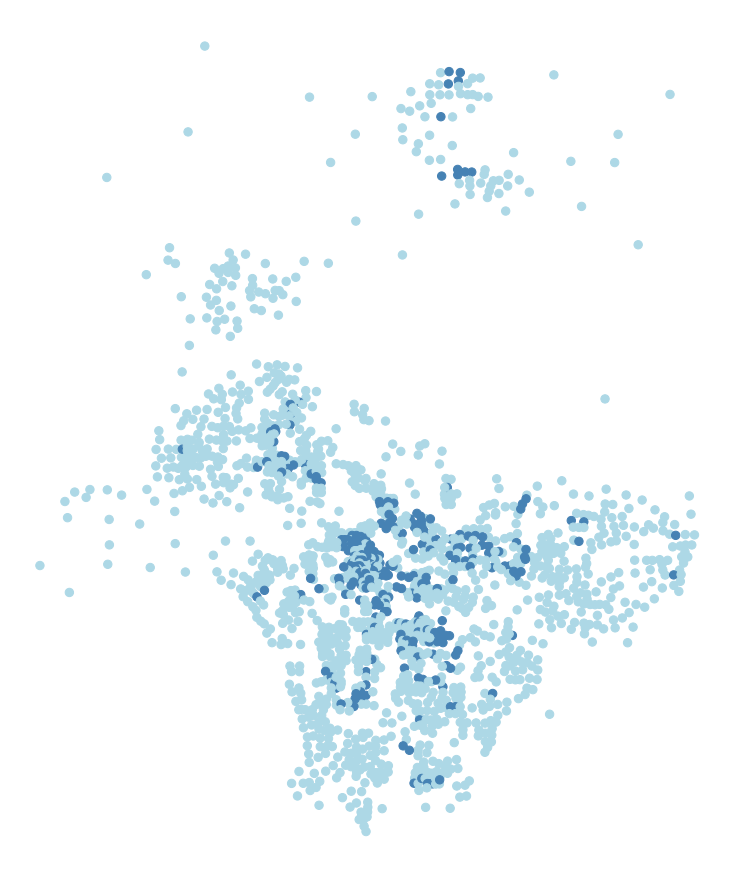

In [16]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [17]:
def get_distance(p1, p2):
    dist = math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    return dist

In [18]:
hospital_locations = pd.read_csv('./datasets/la_hospitals.csv')
hospital_x = hospital_locations

In [19]:
hospitals_x = hospital_locations['X']
hospitals_y = hospital_locations['Y']

hospitals = []
for n_long, n_lat in list(zip(hospitals_x, hospitals_y)):
    if (n_lat<=la_lat_n and n_lat>=la_lat_s and
            n_long<=la_long_e and n_long>=la_long_w):
        hospitals.append([n_long, n_lat, 0])

In [20]:
min(hospitals_y)

33.3391852280922

In [21]:
for i, hospital in enumerate(hospitals):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (hospital[0], hospital[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    hospitals[i][2] = int(label)

In [22]:
for i, values in enumerate(hospitals):
    n_long, n_lat, n_label = values
    city_graph.add_node(i, pos=(n_long, n_lat))
    color_map.append('coral')

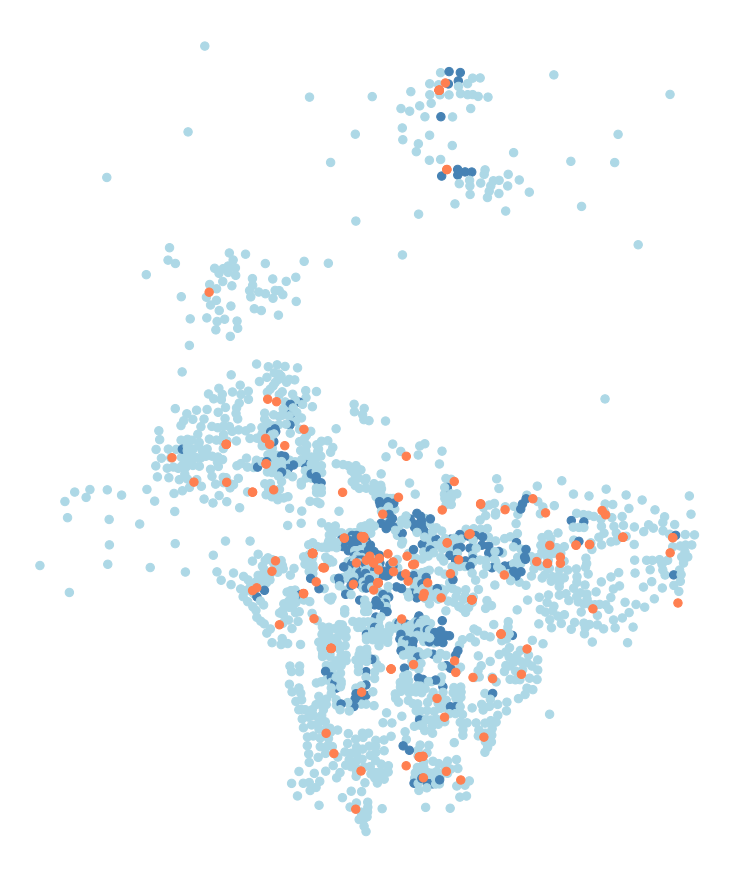

In [23]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [24]:
subway_locations = pd.read_csv('./datasets/la_subway.csv')
subway_x = subway_locations['X']
subway_y = subway_locations['Y']

subway = []
for n_long, n_lat in list(zip(subway_x, subway_y)):
    if (n_lat<=la_lat_n and n_lat>=la_lat_s and
            n_long<=la_long_e and n_long>=la_long_w):
        subway.append([n_long, n_lat, 0])

In [25]:
for i, s in enumerate(subway):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (s[0], s[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    subway[i][2] = int(label)

In [26]:
school_locations = pd.read_csv('./datasets/la_schools.csv')
schools_x = school_locations['X']
schools_y = school_locations['Y']

schools = []
for n_long, n_lat in list(zip(schools_x, schools_y)):
    if (n_lat<=la_lat_n and n_lat>=la_lat_s and
            n_long<=la_long_e and n_long>=la_long_w):
        schools.append([n_long, n_lat, 0])

In [27]:
for i, s in enumerate(schools):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (s[0], s[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    schools[i][2] = int(label)

In [28]:
tract_lats = tracts['lat'].tolist()
tract_longs = tracts['long'].tolist()
tract_labels = tracts['label'].tolist()

In [29]:
# Remove the components you are interested not in seeing
all_nodes = list(zip(tract_longs, tract_lats, tract_labels)) + hospitals + subway + schools

In [30]:
tract_indices = list(range(0, len(tracts)))
all_indices = list(range(0, len(all_nodes)))
hospital_indices = list(range(len(tracts), len(tracts) + len(hospitals)))
subway_indices = list(range(len(tracts) + len(hospitals), len(tracts) + len(hospitals) + len(subway)))
school_indices = list(range(len(tracts) + len(hospitals) + len(subway), len(tracts) + len(hospitals) + len(subway) + len(schools)))

In [32]:
# Creating a graph using NetworkX

# Adding nodes
city_graph = nx.Graph()
color_map = []
for i, values in enumerate(all_nodes):
    n_long, n_lat, n_label = values

    city_graph.add_node(i, pos=(n_long, n_lat))

    if n_label == 1:
        color_map.append('steelblue')
    else:
        color_map.append('lightblue')

# Adding edges
# To observe only one of the networks comment out the unwanted sections
for tract_i in tract_indices+hospital_indices:
    hospital_dict = {}
    for hospital_i in hospital_indices:
        hospital_dict[hospital_i] = get_distance((all_nodes[hospital_i][0], all_nodes[hospital_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(hospital_dict, key=hospital_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

for tract_i in tract_indices+school_indices:
    school_dict = {}
    for school_i in school_indices:
        school_dict[school_i] = get_distance((all_nodes[school_i][0], all_nodes[school_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(school_dict, key=school_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

for tract_i in tract_indices+subway_indices:
    subway_dict = {}
    for subway_i in subway_indices:
        subway_dict[subway_i] = get_distance((all_nodes[subway_i][0], all_nodes[subway_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(subway_dict, key=subway_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

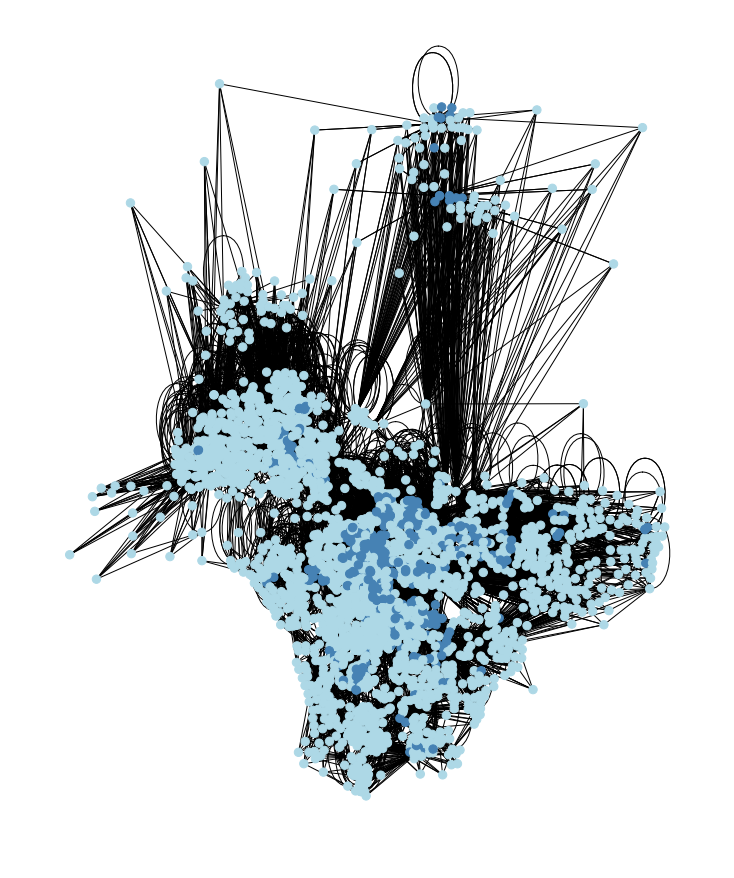

In [33]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [34]:
tracts

,id,lat,long,label
0,6.037101e+09,34.259474,-118.292987,0.0
1,6.037101e+09,34.267721,-118.290147,0.0
2,6.037101e+09,34.252972,-118.290731,0.0
3,6.037101e+09,34.251608,-118.281633,0.0
4,6.037102e+09,34.225079,-118.354188,0.0
...,...,...,...,...
1731,6.037930e+09,34.280333,-117.866141,0.0
1732,6.037980e+09,33.773247,-118.288839,0.0
1733,6.037980e+09,34.092567,-118.534363,0.0
1734,6.037980e+09,34.270047,-118.381334,0.0


In [35]:
hospitals_graph = nx.Graph()
nodes = list(zip(tract_longs, tract_lats, tract_labels))+hospitals

for i, values in enumerate(nodes):
    n_long, n_lat, n_label = values
    hospitals_graph.add_node(i, pos=(n_long, n_lat))

# Adding edges
for tract_i,_ in enumerate(nodes):
    hospital_dict = {}
    for hospital_i,_ in enumerate(hospitals):
        hospital_i += len(tract_labels)
        hospital_dict[hospital_i] = get_distance((nodes[hospital_i][0], nodes[hospital_i][1]),
                                             (nodes[tract_i][0], nodes[tract_i][1]))
    
    closest2 = sorted(hospital_dict, key=hospital_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = nodes[i][1]
        s_long = nodes[i][0]
        distance = get_distance((nodes[tract_i][0], nodes[tract_i][1]),
                                (s_long, s_lat))
        hospitals_graph.add_edge(tract_i, i, weight=distance)


In [36]:
subway_graph = nx.Graph()
nodes = list(zip(tract_longs, tract_lats, tract_labels))+subway

for i, values in enumerate(nodes):
    n_long, n_lat, n_label = values
    subway_graph.add_node(i, pos=(n_long, n_lat))

# Adding edges
for tract_i,_ in enumerate(nodes):
    subway_dict = {}
    for subway_i,_ in enumerate(subway):
        subway_i += len(tract_labels)
        subway_dict[subway_i] = get_distance((nodes[subway_i][0], nodes[subway_i][1]),
                                             (nodes[tract_i][0], nodes[tract_i][1]))
    
    closest2 = sorted(subway_dict, key=subway_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = nodes[i][1]
        s_long = nodes[i][0]
        distance = get_distance((nodes[tract_i][0], nodes[tract_i][1]),
                                (s_long, s_lat))
        subway_graph.add_edge(tract_i, i, weight=distance)


In [37]:
schools_graph = nx.Graph()
nodes = list(zip(tract_longs, tract_lats, tract_labels))+schools

for i, values in enumerate(nodes):
    n_long, n_lat, n_label = values
    schools_graph.add_node(i, pos=(n_long, n_lat))

# Adding edges
for tract_i,_ in enumerate(nodes):
    schools_dict = {}
    for school_i,_ in enumerate(schools):
        school_i += len(tract_labels)
        schools_dict[school_i] = get_distance((nodes[school_i][0], nodes[school_i][1]),
                                             (nodes[tract_i][0], nodes[tract_i][1]))
    
    closest2 = sorted(schools_dict, key=schools_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = nodes[i][1]
        s_long = nodes[i][0]
        distance = get_distance((nodes[tract_i][0], nodes[tract_i][1]),
                                (s_long, s_lat))
        schools_graph.add_edge(tract_i, i, weight=distance)


In [38]:
def from_networkx(G, labels):
    G = nx.convert_node_labels_to_integers(G)
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
    data = {}
    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass
    data['edge_index'] = edge_index.view(2, -1)
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()
    data.x=torch.from_numpy(np.eye(data.num_nodes))

    all_indices = list(range(0, data.num_nodes))
    random.shuffle(all_indices)
    train_indices = all_indices[0:int(data.num_nodes*0.8)]
    test_indices = all_indices[int(data.num_nodes*0.8):data.num_nodes]

    train_mask = np.array([False]*data.num_nodes)
    train_mask[train_indices] = True
    data.train_mask = torch.from_numpy(train_mask)

    test_mask = np.array([False]*data.num_nodes)
    test_mask[test_indices] = True
    data.test_mask=torch.from_numpy(test_mask)
    
    data.y = torch.from_numpy(labels)
    
    return data

labels = [int(label) for _,_,label in all_nodes]
y = np.asarray(labels)

data = from_networkx(city_graph, y)

In [39]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        # super(GCN, self).__init__()
        # torch.manual_seed(12345)
        # self.conv1 = GCNConv(data.num_features, hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, 2)

        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 4)

    def forward(self, x, edge_index):
        # x = self.conv1(x, edge_index)
        # x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.conv2(x, edge_index)
        
        x = self.conv1(x, edge_index)
        x = x.tanh()
        x = self.conv2(x, edge_index)
        x = x.tanh()
        x = self.conv3(x, edge_index)
        x = x.tanh()  # Final GNN embedding space.
        out = self.classifier(x)

        return x

model = GCN(hidden_channels=16)
model.eval()
print(model)

GCN(
  (conv1): GCNConv(3186, 16)
  (conv2): GCNConv(16, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [40]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(dataset):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(dataset.x.to(torch.float), dataset.edge_index)  # Perform a single forward pass.
      loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(dataset):
      model.eval()
      out = model(dataset.x.to(torch.float), dataset.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(dataset.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

loss_lst = []
for epoch in range(1, 300):
    loss = train(data)
    loss_lst.append(float(loss))
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6953
Epoch: 002, Loss: 0.5997
Epoch: 003, Loss: 0.5281
Epoch: 004, Loss: 0.4732
Epoch: 005, Loss: 0.4318
Epoch: 006, Loss: 0.4008
Epoch: 007, Loss: 0.3765
Epoch: 008, Loss: 0.3555
Epoch: 009, Loss: 0.3352
Epoch: 010, Loss: 0.3143
Epoch: 011, Loss: 0.2928
Epoch: 012, Loss: 0.2720
Epoch: 013, Loss: 0.2538
Epoch: 014, Loss: 0.2393
Epoch: 015, Loss: 0.2285
Epoch: 016, Loss: 0.2207
Epoch: 017, Loss: 0.2147
Epoch: 018, Loss: 0.2098
Epoch: 019, Loss: 0.2055
Epoch: 020, Loss: 0.2014
Epoch: 021, Loss: 0.1975
Epoch: 022, Loss: 0.1939
Epoch: 023, Loss: 0.1908
Epoch: 024, Loss: 0.1883
Epoch: 025, Loss: 0.1865
Epoch: 026, Loss: 0.1854
Epoch: 027, Loss: 0.1845
Epoch: 028, Loss: 0.1838
Epoch: 029, Loss: 0.1828
Epoch: 030, Loss: 0.1817
Epoch: 031, Loss: 0.1806
Epoch: 032, Loss: 0.1796
Epoch: 033, Loss: 0.1789
Epoch: 034, Loss: 0.1785
Epoch: 035, Loss: 0.1782
Epoch: 036, Loss: 0.1779
Epoch: 037, Loss: 0.1776
Epoch: 038, Loss: 0.1772
Epoch: 039, Loss: 0.1769
Epoch: 040, Loss: 0.1767


In [41]:
out = model(data.x.to(torch.float), data.edge_index)

In [42]:
pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
true_vals = data.y[data.test_mask]

In [43]:
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8542


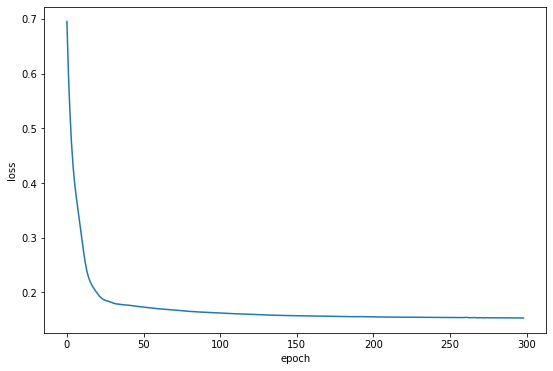

In [44]:
plt.figure(figsize=(9,6))
plt.plot(range(0, len(loss_lst)), loss_lst)
plt.xlabel("epoch")
plt.ylabel("loss");

In [45]:
data = from_networkx(hospitals_graph, y[tract_indices+hospital_indices])
model = GCN(hidden_channels=16)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

loss_lst = []
for epoch in range(1, 300):
    loss = train(data)
    loss_lst.append(float(loss))
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

out = model(data.x.to(torch.float), data.edge_index)
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

GCN(
  (conv1): GCNConv(1878, 16)
  (conv2): GCNConv(16, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)
Epoch: 001, Loss: 0.6927
Epoch: 002, Loss: 0.6325
Epoch: 003, Loss: 0.5780
Epoch: 004, Loss: 0.5283
Epoch: 005, Loss: 0.4838
Epoch: 006, Loss: 0.4457
Epoch: 007, Loss: 0.4146
Epoch: 008, Loss: 0.3899
Epoch: 009, Loss: 0.3700
Epoch: 010, Loss: 0.3534
Epoch: 011, Loss: 0.3386
Epoch: 012, Loss: 0.3245
Epoch: 013, Loss: 0.3103
Epoch: 014, Loss: 0.2954
Epoch: 015, Loss: 0.2801
Epoch: 016, Loss: 0.2645
Epoch: 017, Loss: 0.2494
Epoch: 018, Loss: 0.2355
Epoch: 019, Loss: 0.2234
Epoch: 020, Loss: 0.2135
Epoch: 021, Loss: 0.2058
Epoch: 022, Loss: 0.2001
Epoch: 023, Loss: 0.1956
Epoch: 024, Loss: 0.1920
Epoch: 025, Loss: 0.1890
Epoch: 026, Loss: 0.1864
Epoch: 027, Loss: 0.1841
Epoch: 028, Loss: 0.1819
Epoch: 029, Loss: 0.1799
Epoch: 030, Loss: 0.1779
Epoch: 031, Loss: 0.1760
Epoch: 032, Loss: 0.1742
Epoch: 033, Loss: 0.1726
Epoch: 034, Loss: 0.171

In [46]:
out = model(data.x.to(torch.float), data.edge_index)

In [47]:
pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
true_vals = data.y[data.test_mask]

In [48]:
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8032


In [49]:
roc_auc_score(true_vals, pred_vals)

0.5647035256410257

In [50]:
confusion_matrix(true_vals, pred_vals)

array([[289,  23],
       [ 51,  13]])

In [51]:
sum(true_vals)/len(true_vals)

tensor(0.1702)

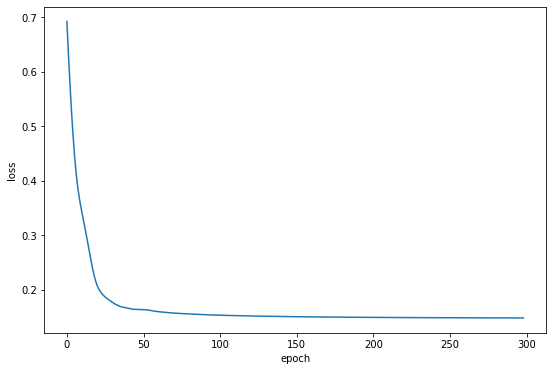

In [52]:
plt.figure(figsize=(9,6))
plt.plot(range(0, len(loss_lst)), loss_lst)
plt.xlabel("epoch")
plt.ylabel("loss");

In [53]:
data = from_networkx(subway_graph, y[tract_indices+subway_indices])
model = GCN(hidden_channels=16)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

loss_lst = []
for epoch in range(1, 300):
    loss = train(data)
    loss_lst.append(float(loss))
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

out = model(data.x.to(torch.float), data.edge_index)
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

GCN(
  (conv1): GCNConv(1809, 16)
  (conv2): GCNConv(16, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)
Epoch: 001, Loss: 0.6938
Epoch: 002, Loss: 0.6522
Epoch: 003, Loss: 0.6127
Epoch: 004, Loss: 0.5747
Epoch: 005, Loss: 0.5389
Epoch: 006, Loss: 0.5061
Epoch: 007, Loss: 0.4765
Epoch: 008, Loss: 0.4503
Epoch: 009, Loss: 0.4271
Epoch: 010, Loss: 0.4065
Epoch: 011, Loss: 0.3880
Epoch: 012, Loss: 0.3709
Epoch: 013, Loss: 0.3546
Epoch: 014, Loss: 0.3387
Epoch: 015, Loss: 0.3228
Epoch: 016, Loss: 0.3069
Epoch: 017, Loss: 0.2911
Epoch: 018, Loss: 0.2758
Epoch: 019, Loss: 0.2615
Epoch: 020, Loss: 0.2486
Epoch: 021, Loss: 0.2372
Epoch: 022, Loss: 0.2274
Epoch: 023, Loss: 0.2191
Epoch: 024, Loss: 0.2120
Epoch: 025, Loss: 0.2061
Epoch: 026, Loss: 0.2010
Epoch: 027, Loss: 0.1966
Epoch: 028, Loss: 0.1927
Epoch: 029, Loss: 0.1892
Epoch: 030, Loss: 0.1860
Epoch: 031, Loss: 0.1831
Epoch: 032, Loss: 0.1804
Epoch: 033, Loss: 0.1780
Epoch: 034, Loss: 0.176

In [54]:
out = model(data.x.to(torch.float), data.edge_index)
pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
true_vals = data.y[data.test_mask].tolist()

In [55]:
out

tensor([[ 0.9916, -0.9861],
        [ 0.9916, -0.9861],
        [ 0.9916, -0.9861],
        ...,
        [ 0.9996, -0.9991],
        [ 0.9997, -0.9992],
        [ 0.9999, -0.9997]], grad_fn=<TanhBackward0>)

In [57]:
all_preds_lst = []
all_true_lst = []

for iteration in range(0, 10):
    data = from_networkx(hospitals_graph, y[tract_indices+hospital_indices])
    model = GCN(hidden_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 200):
        loss = train(data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    out = model(data.x.to(torch.float), data.edge_index)
    pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
    true_vals = data.y[data.test_mask].tolist()

    all_preds_lst.extend(pred_vals)
    all_true_lst.extend(true_vals)

    print(len(pred_vals), len(all_preds_lst))


Epoch: 001, Loss: 0.6923
Epoch: 002, Loss: 0.6290
Epoch: 003, Loss: 0.5725
Epoch: 004, Loss: 0.5215
Epoch: 005, Loss: 0.4764
Epoch: 006, Loss: 0.4380
Epoch: 007, Loss: 0.4065
Epoch: 008, Loss: 0.3815
Epoch: 009, Loss: 0.3614
Epoch: 010, Loss: 0.3448
Epoch: 011, Loss: 0.3300
Epoch: 012, Loss: 0.3161
Epoch: 013, Loss: 0.3022
Epoch: 014, Loss: 0.2879
Epoch: 015, Loss: 0.2731
Epoch: 016, Loss: 0.2581
Epoch: 017, Loss: 0.2435
Epoch: 018, Loss: 0.2301
Epoch: 019, Loss: 0.2185
Epoch: 020, Loss: 0.2091
Epoch: 021, Loss: 0.2019
Epoch: 022, Loss: 0.1965
Epoch: 023, Loss: 0.1923
Epoch: 024, Loss: 0.1889
Epoch: 025, Loss: 0.1859
Epoch: 026, Loss: 0.1832
Epoch: 027, Loss: 0.1806
Epoch: 028, Loss: 0.1783
Epoch: 029, Loss: 0.1761
Epoch: 030, Loss: 0.1742
Epoch: 031, Loss: 0.1725
Epoch: 032, Loss: 0.1711
Epoch: 033, Loss: 0.1698
Epoch: 034, Loss: 0.1685
Epoch: 035, Loss: 0.1673
Epoch: 036, Loss: 0.1662
Epoch: 037, Loss: 0.1652
Epoch: 038, Loss: 0.1642
Epoch: 039, Loss: 0.1635
Epoch: 040, Loss: 0.1631


In [58]:
print(classification_report(all_true_lst, all_preds_lst))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3152
           1       0.42      0.21      0.28       608

    accuracy                           0.83      3760
   macro avg       0.64      0.58      0.59      3760
weighted avg       0.79      0.83      0.80      3760



In [59]:
roc_auc_score(all_true_lst, all_preds_lst)

0.5758582687683677

In [60]:
preds_df = pd.DataFrame([all_true_lst, all_preds_lst]).T
preds_df.columns = ['true', 'prediction']
preds_df.to_csv("./datasets/la_hospitals_predictions.csv", encoding='utf-8', index=False)

In [61]:
all_preds_lst = []
all_true_lst = []

for iteration in range(0, 10):
    data = from_networkx(subway_graph, y[tract_indices+subway_indices])
    model = GCN(hidden_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 200):
        loss = train(data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    out = model(data.x.to(torch.float), data.edge_index)
    pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
    true_vals = data.y[data.test_mask].tolist()

    all_preds_lst.extend(pred_vals)
    all_true_lst.extend(true_vals)

    print(len(pred_vals), len(all_preds_lst))


Epoch: 001, Loss: 0.6937
Epoch: 002, Loss: 0.6530
Epoch: 003, Loss: 0.6141
Epoch: 004, Loss: 0.5766
Epoch: 005, Loss: 0.5411
Epoch: 006, Loss: 0.5085
Epoch: 007, Loss: 0.4791
Epoch: 008, Loss: 0.4531
Epoch: 009, Loss: 0.4301
Epoch: 010, Loss: 0.4097
Epoch: 011, Loss: 0.3914
Epoch: 012, Loss: 0.3744
Epoch: 013, Loss: 0.3583
Epoch: 014, Loss: 0.3425
Epoch: 015, Loss: 0.3268
Epoch: 016, Loss: 0.3109
Epoch: 017, Loss: 0.2951
Epoch: 018, Loss: 0.2798
Epoch: 019, Loss: 0.2653
Epoch: 020, Loss: 0.2520
Epoch: 021, Loss: 0.2403
Epoch: 022, Loss: 0.2301
Epoch: 023, Loss: 0.2214
Epoch: 024, Loss: 0.2141
Epoch: 025, Loss: 0.2080
Epoch: 026, Loss: 0.2028
Epoch: 027, Loss: 0.1982
Epoch: 028, Loss: 0.1942
Epoch: 029, Loss: 0.1906
Epoch: 030, Loss: 0.1873
Epoch: 031, Loss: 0.1844
Epoch: 032, Loss: 0.1818
Epoch: 033, Loss: 0.1795
Epoch: 034, Loss: 0.1775
Epoch: 035, Loss: 0.1758
Epoch: 036, Loss: 0.1745
Epoch: 037, Loss: 0.1732
Epoch: 038, Loss: 0.1721
Epoch: 039, Loss: 0.1712
Epoch: 040, Loss: 0.1703


In [62]:
print(classification_report(all_true_lst, all_preds_lst))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      3016
           1       0.59      0.13      0.21       604

    accuracy                           0.84      3620
   macro avg       0.72      0.55      0.56      3620
weighted avg       0.81      0.84      0.79      3620



In [63]:
roc_auc_score(all_true_lst, all_preds_lst)

0.5549552497057635

In [64]:
preds_df = pd.DataFrame([all_true_lst, all_preds_lst]).T
preds_df.columns = ['true', 'prediction']
preds_df.to_csv("./datasets/la_subway_predictions.csv", encoding='utf-8', index=False)

In [65]:
all_preds_lst = []
all_true_lst = []

for iteration in range(0, 10):
    data = from_networkx(schools_graph, y[tract_indices+school_indices])
    model = GCN(hidden_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 300):
        loss = train(data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    out = model(data.x.to(torch.float), data.edge_index)
    pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
    true_vals = data.y[data.test_mask].tolist()

    all_preds_lst.extend(pred_vals)
    all_true_lst.extend(true_vals)

    print(len(pred_vals), len(all_preds_lst))


Epoch: 001, Loss: 0.6930
Epoch: 002, Loss: 0.5882
Epoch: 003, Loss: 0.5066
Epoch: 004, Loss: 0.4460
Epoch: 005, Loss: 0.4028
Epoch: 006, Loss: 0.3716
Epoch: 007, Loss: 0.3473
Epoch: 008, Loss: 0.3256
Epoch: 009, Loss: 0.3042
Epoch: 010, Loss: 0.2824
Epoch: 011, Loss: 0.2609
Epoch: 012, Loss: 0.2412
Epoch: 013, Loss: 0.2245
Epoch: 014, Loss: 0.2113
Epoch: 015, Loss: 0.2014
Epoch: 016, Loss: 0.1942
Epoch: 017, Loss: 0.1888
Epoch: 018, Loss: 0.1845
Epoch: 019, Loss: 0.1807
Epoch: 020, Loss: 0.1771
Epoch: 021, Loss: 0.1738
Epoch: 022, Loss: 0.1708
Epoch: 023, Loss: 0.1684
Epoch: 024, Loss: 0.1665
Epoch: 025, Loss: 0.1651
Epoch: 026, Loss: 0.1641
Epoch: 027, Loss: 0.1633
Epoch: 028, Loss: 0.1625
Epoch: 029, Loss: 0.1617
Epoch: 030, Loss: 0.1610
Epoch: 031, Loss: 0.1603
Epoch: 032, Loss: 0.1597
Epoch: 033, Loss: 0.1593
Epoch: 034, Loss: 0.1590
Epoch: 035, Loss: 0.1589
Epoch: 036, Loss: 0.1587
Epoch: 037, Loss: 0.1585
Epoch: 038, Loss: 0.1583
Epoch: 039, Loss: 0.1581
Epoch: 040, Loss: 0.1581


In [66]:
print(classification_report(all_true_lst, all_preds_lst))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      4717
           1       0.78      0.59      0.67      1143

    accuracy                           0.89      5860
   macro avg       0.84      0.77      0.80      5860
weighted avg       0.88      0.89      0.88      5860



In [67]:
roc_auc_score(all_true_lst, all_preds_lst)

0.7731738906815151

In [68]:
preds_df = pd.DataFrame([all_true_lst, all_preds_lst]).T
preds_df.columns = ['true', 'prediction']
preds_df.to_csv("./datasets/la_schools_predictions.csv", encoding='utf-8', index=False)

In [69]:
all_preds_lst = []
all_true_lst = []

for iteration in range(0, 10):
    data = from_networkx(city_graph, y)
    model = GCN(hidden_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 300):
        loss = train(data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    out = model(data.x.to(torch.float), data.edge_index)
    pred_vals = out.argmax(dim=1)[data.test_mask].tolist()
    true_vals = data.y[data.test_mask].tolist()

    all_preds_lst.extend(pred_vals)
    all_true_lst.extend(true_vals)

    print(len(pred_vals), len(all_preds_lst))


Epoch: 001, Loss: 0.6947
Epoch: 002, Loss: 0.5993
Epoch: 003, Loss: 0.5291
Epoch: 004, Loss: 0.4750
Epoch: 005, Loss: 0.4342
Epoch: 006, Loss: 0.4036
Epoch: 007, Loss: 0.3797
Epoch: 008, Loss: 0.3594
Epoch: 009, Loss: 0.3401
Epoch: 010, Loss: 0.3203
Epoch: 011, Loss: 0.3000
Epoch: 012, Loss: 0.2801
Epoch: 013, Loss: 0.2620
Epoch: 014, Loss: 0.2469
Epoch: 015, Loss: 0.2352
Epoch: 016, Loss: 0.2268
Epoch: 017, Loss: 0.2208
Epoch: 018, Loss: 0.2161
Epoch: 019, Loss: 0.2120
Epoch: 020, Loss: 0.2079
Epoch: 021, Loss: 0.2040
Epoch: 022, Loss: 0.2003
Epoch: 023, Loss: 0.1971
Epoch: 024, Loss: 0.1946
Epoch: 025, Loss: 0.1926
Epoch: 026, Loss: 0.1912
Epoch: 027, Loss: 0.1900
Epoch: 028, Loss: 0.1890
Epoch: 029, Loss: 0.1879
Epoch: 030, Loss: 0.1868
Epoch: 031, Loss: 0.1856
Epoch: 032, Loss: 0.1846
Epoch: 033, Loss: 0.1837
Epoch: 034, Loss: 0.1829
Epoch: 035, Loss: 0.1824
Epoch: 036, Loss: 0.1820
Epoch: 037, Loss: 0.1816
Epoch: 038, Loss: 0.1812
Epoch: 039, Loss: 0.1808
Epoch: 040, Loss: 0.1805


In [70]:
print(classification_report(all_true_lst, all_preds_lst))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      5116
           1       0.66      0.59      0.62      1264

    accuracy                           0.86      6380
   macro avg       0.78      0.76      0.77      6380
weighted avg       0.85      0.86      0.85      6380



In [71]:
roc_auc_score(all_true_lst, all_preds_lst)

0.7564859190823527

In [72]:
preds_df = pd.DataFrame([all_true_lst, all_preds_lst]).T
preds_df.columns = ['true', 'prediction']
preds_df.head(20)
preds_df.to_csv("./datasets/la_everything_predictions.csv", encoding='utf-8', index=False)